In [1]:
from plot_lib import *
import pandas as pd 
from evaluation import *
import os
import re

DATA_DIR = 'recommender_outputs/poster_plots/' 


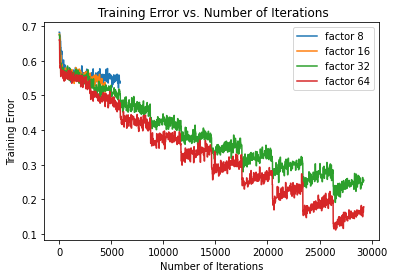

In [30]:
factor_arr = [8, 16, 32, 64]
error_dict = {}
for factor in factor_arr:
    df = pd.read_csv(f'recommender_outputs/math-german-no-features-{factor}_loss.csv')
    error_dict[f'factor {factor}'] = [df['loss_value'], df['iteration']]

iteration_error_plot(error_dict, batch_size=64)

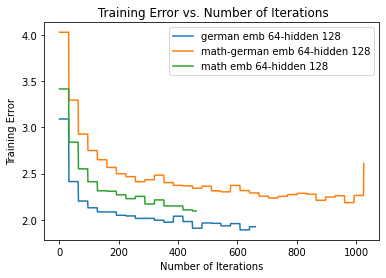

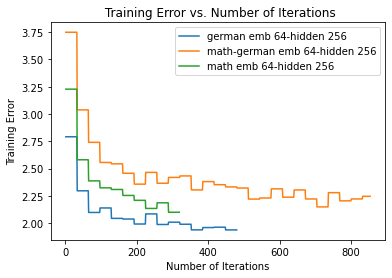

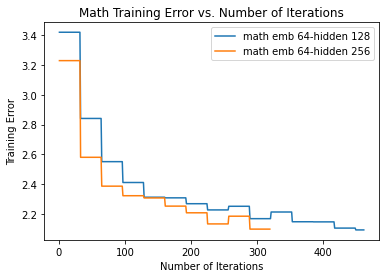

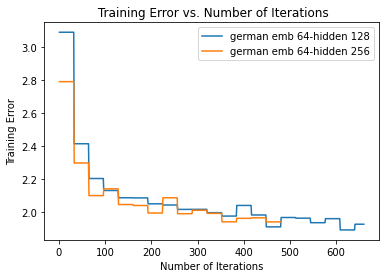

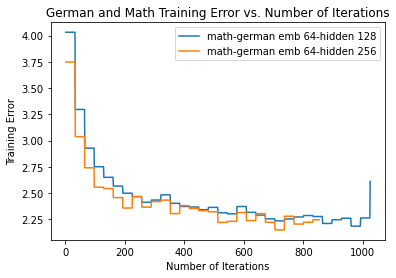

In [14]:

def error_specific_model_plot(model_name, german=True, math=True):
    """
    IMPORTANT NOTE: IF german=math=false then do not consider dataset splitting i.e. either 'math', 'german', 'math-german' are accepted
    """
    error_dict = {}
    title = ""
    if (german and math):
        title = 'German and Math'
    else:
        title = 'German' if german else ''
        title = 'Math' if math else ''

    for filename in os.listdir(DATA_DIR):
        if 'loss' not in filename or model_name not in filename:
            continue
        if (german or math):
            if (german and math and 'math-german' not in filename):
                continue
            if (not german and 'german' in filename) or (not math and 'math' in filename):
                continue

        df = pd.read_csv(f'{DATA_DIR}/{filename}')
        name = ' '.join(filename.split('-gru4rec-topic-'))
        name = ' '.join(name.split('-dim-'))
        error_dict[name[0: name.find('_')]] = [df['loss_value'], df['iteration']]
        
    iteration_error_plot(error_dict, title, batch_size=32)

error_specific_model_plot('gru4rec-topic-emb-dim-64-hidden-dim-128', math=False, german=False)

error_specific_model_plot('gru4rec-topic-emb-dim-64-hidden-dim-256',  math=False, german=False)

error_specific_model_plot('gru4rec', german=False)

error_specific_model_plot('gru4rec', math=False)

error_specific_model_plot('gru4rec')

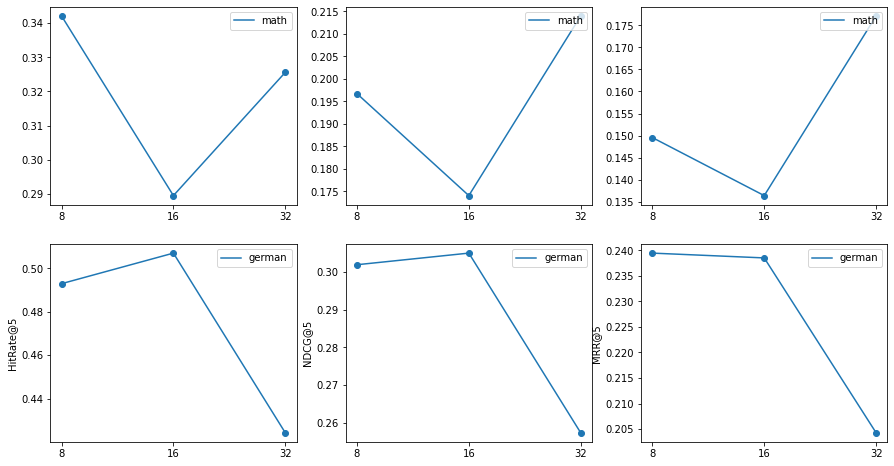

In [84]:
def create_plot_predictive_factor_eval(factor_arr, n):
    model = {}
    math_ids = pd.read_csv('math_ids')['math_ids']
    german_ids = pd.read_csv('german_ids')['german_ids']

    for factor in factor_arr:
        plot_dict = HitRate_NDCG_MRR_from_CSV(f'recommender_outputs/math-german-no-features-{factor}_probas.csv', n=n, math_ids=math_ids, german_ids=german_ids)
        model[str(factor)] = plot_dict

    models_eval_plot(model)

create_plot_predictive_factor_eval([8, 16, 32], 5)

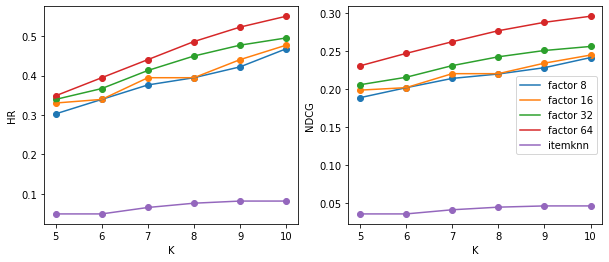

In [ ]:
def create_plot_k_eval(k_arr, factor_arr):
    hr_dict, ndcg_dict = {}, {}
    for factor in factor_arr:
        hr_dict[f'factor {factor}'] = []
        ndcg_dict[f'factor {factor}'] = []
        for n in k_arr:
            hr, ndcg, mrr  = HitRate_NDCG_MRR(f'{DATA_DIR}/math-german-no-features-{factor}_probas.csv', n)
            hr_dict[f'factor {factor}'].append(hr)
            ndcg_dict[f'factor {factor}'].append(ndcg)
    hr_dict[f'itemknn'], ndcg_dict[f'itemknn'] =[], []
    for n in k_arr:
            hr, ndcg, mrr  = HitRate_NDCG_MRR(f'{DATA_DIR}/itemknn_probas.csv', n)
            hr_dict[f'itemknn'].append(hr)
            ndcg_dict[f'itemknn'].append(ndcg)
    k_eval_plot(k_arr, hr_dict, ndcg_dict)

create_plot_k_eval([5, 6, 7, 8, 9, 10], [8, 16, 32, 64])


# Create plots from metrics.csv

Copy all the metrics.csv to one single folder, rename with model name (e.g. 'ncf_features_32.csv' or smth), and then run 'collect_stats_from_dir'. Will return a dict containing each model, and for each model containing another dict with the various stats for plotting (training loss & steps, val loss & steps, various val metrics & steps, various test metrics)

In [2]:

import os 
import pandas as pd

def collect_stats_from_dir(directory, metrics = ['HitRate@10', 'NDCG@10', 'MRR@10']):
    data = dict()

    if directory[-1] != '/':
        directory = directory + '/'
   
    for filename in os.listdir(directory):
        math = False
        german = False

        if len(filename) <= 4 or filename[-4:] != '.csv':
            continue
        math = 'math' in filename
        german = 'german' in filename

        stats = dict()
        df = pd.read_csv(directory + filename)
        
        train = df[~df['train_loss_step'].isna()]

        stats[('train_loss','steps')] = (train['train_loss_step'], train['step'])

        validation = df[~df['val_loss'].isna()]
        
        stats[('val_loss','steps')] = (validation['val_loss'], validation['step'])

        is_both = math and german
        prefix = 'math' if math else 'german'
        for m in metrics:
            if is_both:       
                for pre in ['math', 'german']:
                    stats[(f'val_{pre}_{m}_steps')] = (validation[pre+'_'+m], validation['step'])
            else:
                stats[(f'val_{prefix}_{m}_steps')] = (validation[m], validation['step'])
               
        test = df[df['train_loss_step'].isna()]
        test = test[test['val_loss'].isna()]
       
        if len(test):
            for m in metrics:
                if is_both:       
                    for pre in ['math', 'german']:
                        stats[(f'test_{pre}_{m}_steps')] = test[pre+'_'+m].iloc[-1]
                else:
                    stats[(f'test_{prefix}_{m}_steps')] = test[m].iloc[-1]

        data[filename[:-4]] = stats
    
    return data

In [3]:
data = collect_stats_from_dir('recommender_outputs/recommender_david_outputs/')

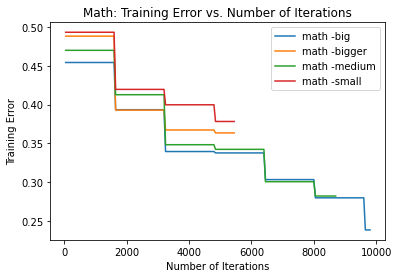

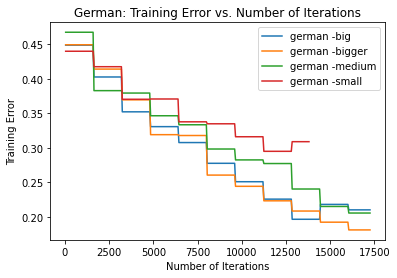

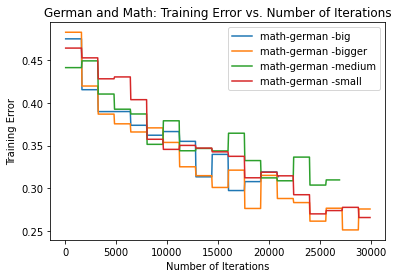

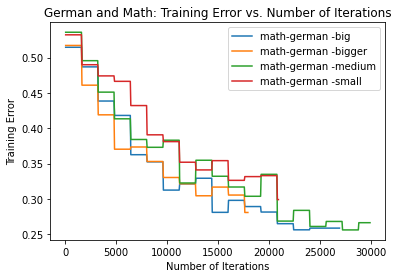

In [28]:
from plot_lib import iteration_error_plot

def ncf_model_plot(model_name, german=True, math=True):
    error_dict = {}
    title = ""
    if (german and math):
        title = 'German and Math'
    else:
        title = 'German' if german else 'Math'
    for key, value in data.items():
        if model_name not in key:
            continue
        if (german or math):
            if (german and math and 'math-german' not in key):
                continue
            if (not german and 'german' in key) or (not math and 'math' in key):
                continue
        name = ' '.join(key.split(f'-{model_name}'))
        
        error_dict[name] = [value[('train_loss','steps')][0], value[('train_loss','steps')][1]]
        
    iteration_error_plot(error_dict, title+':')

ncf_model_plot('ncf-with-features', german=False)
ncf_model_plot('ncf-with-features', math=False)
ncf_model_plot('ncf-with-features')
ncf_model_plot('ncf-no-features')

# ncf_model_plot('ncf-no-features')
# ncf_model_plot('math')

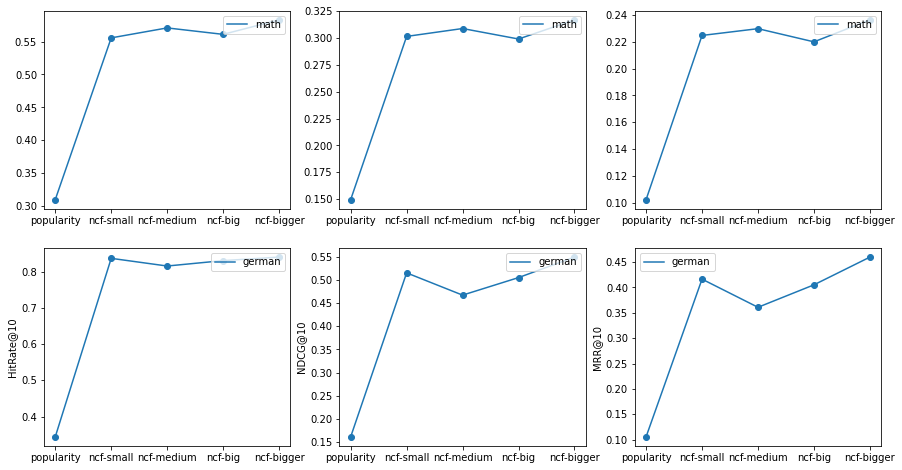

In [101]:
def create_plot_eval(model_csv, data, ncf_list, n, metrics=['HitRate@10', 'NDCG@10', 'MRR@10']):
    
    math_ids = pd.read_csv('math_ids')['math_ids']
    german_ids = pd.read_csv('german_ids')['german_ids']
    model_plots = {}
    for model in model_csv:
        plot_dict = HitRate_NDCG_MRR_from_CSV(f'{DATA_DIR}/{model}', n=n, math_ids=math_ids, german_ids=german_ids)
        model_name = ''.join(model.split('math-german-'))
        model_name = model_name.split('_')[0]
        model_plots[str(model_name)] = plot_dict
        
    for model in ncf_list:
        plot_dict_math, plot_dict_german = {}, {}
    
        for metric in metrics:
            model_name = ''.join(model.split('math-german-'))
            model_name = ''.join(model_name.split('-with-features'))
            plot_dict_math[metric], plot_dict_german[metric] = data[model][f'test_math_{metric}_steps'], data[model][f'test_german_{metric}_steps']
        model_plots[str(model_name)] = {'math':plot_dict_math, 'german':plot_dict_german}

    models_eval_plot(model_plots)

pd.read_csv(f'{DATA_DIR}/math-german-popularity_probas.csv')
model_list = ['math-german-popularity_probas.csv']
ncf_list = ['math-german-ncf-with-features-small', 'math-german-ncf-with-features-medium', 'math-german-ncf-with-features-big', 'math-german-ncf-with-features-bigger']
create_plot_eval(model_list, data, ncf_list, 10)

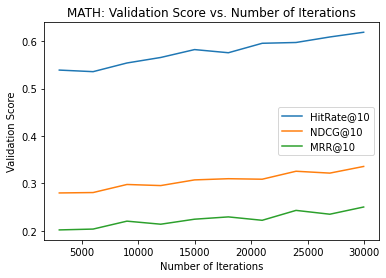

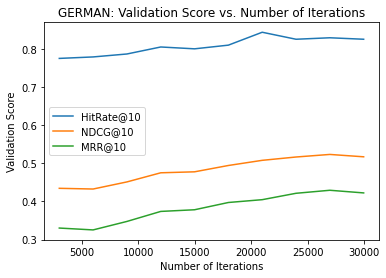

In [4]:
from plot_lib import iteration_validation_score_plot

def create_plot_validation_eval(data, ncf_list, metrics=['HitRate@10', 'NDCG@10', 'MRR@10']):
    for model in ncf_list:
        plot_dict_math, plot_dict_german = {}, {}
    
        for metric in metrics:
            model_name = ''.join(model.split('math-german-'))
            model_name = ''.join(model_name.split('-with-features'))
            
            math_data, german_data = data[model][f'val_math_{metric}_steps'], data[model][f'val_german_{metric}_steps']
            plot_dict_math[metric] = [math_data[0], math_data[1]]
            plot_dict_german[metric] = [german_data[0], german_data[1]]

        iteration_validation_score_plot(plot_dict_math, 'MATH: ')
        iteration_validation_score_plot(plot_dict_german, 'GERMAN: ')

create_plot_validation_eval(data, ['math-german-ncf-with-features-bigger'])

In [ ]:

# Define the directory path where the files are located
directory = "recommender_outputs/recommender_david_outputs/"

# Define the pattern to match the file names
pattern = r"^ncf_(math_german_|math_|german_)(.*)$"

# Iterate over the files in the directory
for filename in os.listdir(directory):
    # Check if the file name matches the pattern
    if re.match(pattern, filename):
        new_filename = re.match(pattern, filename).group(1) + 'ncf-'+ re.match(pattern, filename).group(2)
        new_filename = new_filename.replace('_', '-')
        # Get the full path of the file
        old_filepath = os.path.join(directory, filename)
        new_filepath = os.path.join(directory, new_filename)
        # Rename the file
        os.rename(old_filepath, new_filepath)


In [5]:

math_ids = pd.read_csv('math_ids')['math_ids']
german_ids = pd.read_csv('german_ids')['german_ids']
print(HitRate_NDCG_MRR_from_CSV(
    'recommender_outputs/poster_plots/math-german-gru4rec-topic-emb-dim-64-hidden-dim-256_probas.csv',
    math_ids=math_ids,
    german_ids=german_ids,
    ))

{'math': {'HitRate@10': nan, 'NDCG@10': nan, 'MRR@10': nan}, 'german': {'HitRate@10': nan, 'NDCG@10': nan, 'MRR@10': nan}}


c:\Users\HUONG LAN\Codeproject stuff\recommender\evaluation.py:29: RuntimeWarning: Mean of empty slice.
  return {f'HitRate@{n}': np.array(hit_list).mean(), f'NDCG@{n}': np.array(ndcg_list).mean(), f'MRR@{n}': np.array(mrr_list).mean()}
c:\Users\HUONG LAN\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\HUONG LAN\Codeproject stuff\recommender\evaluation.py:29: RuntimeWarning: Mean of empty slice.
  return {f'HitRate@{n}': np.array(hit_list).mean(), f'NDCG@{n}': np.array(ndcg_list).mean(), f'MRR@{n}': np.array(mrr_list).mean()}
c:\Users\HUONG LAN\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
